In [ ]:
from mnist_src.dataset import MNIST
import torch 
from torch import nn 
import os
#from adopt import ADOPT
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

DEVICE='cuda' if torch.cuda.is_available() else 'cpu' 

dataset=MNIST() 

In [ ]:
import os
import torch
from torchvision import datasets, transforms


def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def split_and_save(dataset, output_dir):
    create_dir(output_dir)

    label_data = {label: [] for label in range(10)}


    for image, label in dataset:
        label_data[label].append((image, label))


    for label, data in label_data.items():
        images, labels = zip(*data)  
        label_tensor = torch.stack(images)  
        label_labels = torch.tensor(labels)  
        file_path = os.path.join(output_dir, f"label_{label}.pt")
        torch.save((label_tensor, label_labels), file_path)

    print(f"Dataset successfully split and saved in {output_dir}")

output_dir = "./mnist_split"


split_and_save(dataset, output_dir)



In [ ]:
def load_label_data(labels, output_dir):
    images, all_labels = [], []
    for label in labels:
        file_path = os.path.join(output_dir, f"label_{label}.pt")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File for label {label} not found in {output_dir}")
        label_images, label_labels = torch.load(file_path)
        images.append(label_images)
        all_labels.append(label_labels)


    combined_images = torch.cat(images)
    combined_labels = torch.cat(all_labels)
    return combined_images, combined_labels

labels_to_load = list(range(10))
images, labels = load_label_data(labels_to_load, output_dir)
print(f"Loaded data for labels {labels_to_load} with shapes: images={images.shape}, labels={labels.shape}")

Loaded data for labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with shapes: images=torch.Size([60000, 1, 28, 28]), labels=torch.Size([60000])


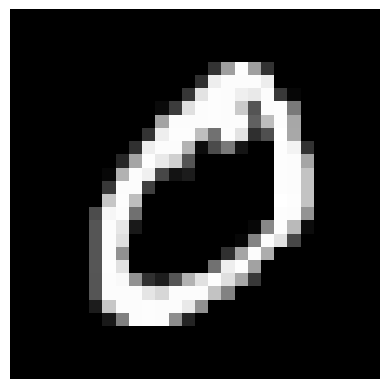

In [4]:
plt.imshow(images[0].squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def create_new_dataset(images, labels):
    return TensorDataset(images, labels)

In [6]:
new_dataset = create_new_dataset(images, labels)
print(f"New dataset created with {len(new_dataset)} samples.")

New dataset created with 60000 samples.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
from Flow_Perturbation.src.GMM_distribution import get_energy_device,sample_NWell,redraw_samples,get_energy_gradient_device
from Flow_Perturbation.src.DDPM import calc_alphas_betas, diffusion_loss_fn, diffusion_loss_fn_v_prediction
from Flow_Perturbation.src.train import train_model_DDPM
from Flow_Perturbation.src.DDPM import interpolate_parameters,DDPMSamplerCoM, DDPMSampler
from Flow_Perturbation.src.utils import  generate_tsampling, modify_samples_torch_batched_K,generate_betasampling
from Flow_Perturbation.src.SMC import generate_doubling_intervals_exclude_start,systematic_resampling,find_closest_larger_element_desc,mc_step,resample_if_needed

In [9]:
rcParams.update({'font.size': 16})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
num_steps = 1000
alphas, betas, alphas_prod, alphas_bar_sqrt, one_minus_alphas_bar_sqrt = calc_alphas_betas(num_steps=num_steps, scaling=6, beta_min=1e-5, beta_max=1e-2)

In [14]:
from torchcfm.models.unet.unet import UNetModelWrapper2

In [ ]:
EPOCH=500
BATCH_SIZE=300

dataloader=DataLoader(new_dataset,batch_size=BATCH_SIZE,shuffle=True)   
model=UNetModelWrapper2(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=(1, 2, 2),
    num_heads=4,
    num_head_channels=32,
    attention_resolutions="16",
    dropout=0.1,
    class_cond=True,
    num_classes=10,
).to(device)
model.train()


UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [16]:

path = 'models/MNIST0-9-128'
model.load_state_dict(torch.load(f'{path}/model.pth', map_location=device))
#model = train_model_DDPM(model, dataloader, path, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps,num_epoch=EPOCH,lr=1e-3, loss_DDPM = diffusion_loss_fn,decay_steps = EPOCH//50)
print('Training done!')
model.eval()

Training done!


UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
if_v = False

In [19]:
import torch
import numpy as np
from scipy.interpolate import CubicSpline
import torch.nn.functional as F
from Flow_Perturbation.src.odesolver import odesolver,odesolver_Huch_dSt


class DDPMSampler:
    def __init__(self, model, st, st_derivative, sigma_t_derivative,at,oat,if_v =False, device = 'cuda:0'):
        self.model = model
        self.st = st
        self.st_derivative = st_derivative
        self.sigma_t_derivative = sigma_t_derivative
        self.at = at
        self.oat = oat
        self.device = device
        self.if_v = if_v

    def score_function(self, x, y, t):
        '''
        Computes the score function for input data x at given time step t.

        The score function is a key concept in generative models, guiding the reverse process of data through a noise process.

        Parameters:
        - x (Tensor): The input data, typically noisy data at a certain time step t.
        - t (Tensor): A scalar or a tensor with the same batch size as x, representing the time step.

        Returns:
        - Tensor: The score function value for the input data x at time step t.
        '''
        # Expand the time step t to match the batch size of x and ensure it's on the correct device
        #print(t.shape,x.shape,y.shape)
        t_repeat = (t * torch.ones(x.shape[0])).to(self.device)
        if self.if_v:
            # use the model to predict \( v_\theta(x_t, t) \)
            pred_velocity = self.model(x, t_repeat, y)
            
            # from \( v_\theta \) derive \( x_0 \)
            sqrt_alpha = torch.tensor(self.at(t))  # \( \sqrt{\alpha_t} \)
            sqrt_one_minus_alpha = torch.tensor(self.oat(t))  # \( \sqrt{1 - \alpha_t} \)
            #x_0 = (x - sqrt_one_minus_alpha * pred_velocity) / sqrt_alpha

            # Predict the noise for the noisy data at the given time step
            pred_noise = sqrt_alpha * pred_velocity + sqrt_one_minus_alpha * x
        else:
            # Use the model to predict the noise for the noisy data at the given time step
            pred_noise = self.model(x, t_repeat, y)
        # Calculate the value of the score function
        return self.st_derivative(t) / self.st(t) * x + self.st(t) * self.sigma_t_derivative(t) * pred_noise
    
    def score_function_rearange(self, t, x, y):
        return self.score_function(x, y, t)
    
    def score_function_1element(self, x, y, t):
        x = x.reshape(-1,x.shape[-1])
        score = self.score_function(x, y, t)
        return score.flatten()
    
    @torch.no_grad()
    def ode_step(self, x, y, t, t_next):
        function = lambda t, x: self.score_function_rearange(t, x, y)
        return odesolver(function, x, t, t_next)
    
    @torch.no_grad()
    def exact_dynamics(self, xT, y, timesteps, method = 'RK4'): 
        xt = xT
        function = lambda t, x: self.score_function_rearange(t, x, y)
        for i in range(len(timesteps)-1):
            t = timesteps[i]
            tnext = timesteps[i+1]
            xt = odesolver(function, xt, t, tnext, method)
            xt=torch.clamp(xt, -2.0, 2.0).detach()
        return xt

In [20]:
st, sigma_t, st_derivative, sigma_t_derivative,at,oat = interpolate_parameters(num_steps, alphas_prod,alphas_bar_sqrt, one_minus_alphas_bar_sqrt)
Sampler = DDPMSampler(model, st, st_derivative, sigma_t_derivative,at,oat,if_v,device)

exact_dynamics = Sampler.exact_dynamics
time_forward = generate_tsampling(0, num_steps-1, 20, 4.0)
time_backward = time_forward[::-1]

In [21]:
batch_size=10
xT=torch.randn(size=(batch_size,1,28,28)).to(device)  # (5,1,24,24)
yT=torch.arange(start=0,end=10,dtype=torch.long).to(device)  # (5,)

In [22]:
#x0 = exact_dynamics(xT, yT, time_backward,method='Euler')
x0 = exact_dynamics(xT, yT, time_backward)

In [23]:
xT_reverse = exact_dynamics(x0, yT, time_forward)

In [24]:
xT - xT_reverse

tensor([[[[-4.9005e-03,  4.1543e-03, -2.5858e-03,  ...,  4.9197e-02,
           -3.0908e-03, -3.3852e-03],
          [-2.3261e-03, -2.1411e-03, -1.3818e-03,  ..., -2.1477e-03,
           -3.8444e-03, -4.3223e-03],
          [-1.0487e-03, -4.5388e-03, -2.7982e-03,  ..., -3.1936e-03,
           -4.1786e-03, -6.8828e-04],
          ...,
          [-5.8410e-04, -1.9828e-03,  1.4812e-04,  ..., -2.6216e-03,
           -4.7266e-03, -3.6339e-03],
          [-3.7710e-03, -1.5146e-04, -2.1980e-03,  ..., -3.6637e-03,
           -3.0351e-03, -3.0867e-03],
          [-3.3776e-03,  7.9191e-04, -9.3365e-04,  ..., -6.0993e-04,
           -4.0153e-03,  1.1182e-04]]],


        [[[ 1.7013e-03, -8.0247e-03, -2.0816e-03,  ..., -9.3764e-04,
            2.0003e-03, -2.7996e-03],
          [-6.9567e-03,  5.6088e-04, -2.2117e-03,  ..., -7.2136e-03,
            1.8525e-04, -3.7034e-03],
          [-7.6385e-03, -1.8587e-03, -2.6560e-01,  ..., -7.2443e-02,
           -2.9741e-03, -1.5689e-03],
          ...,
   

In [25]:
x0.shape

torch.Size([10, 1, 28, 28])

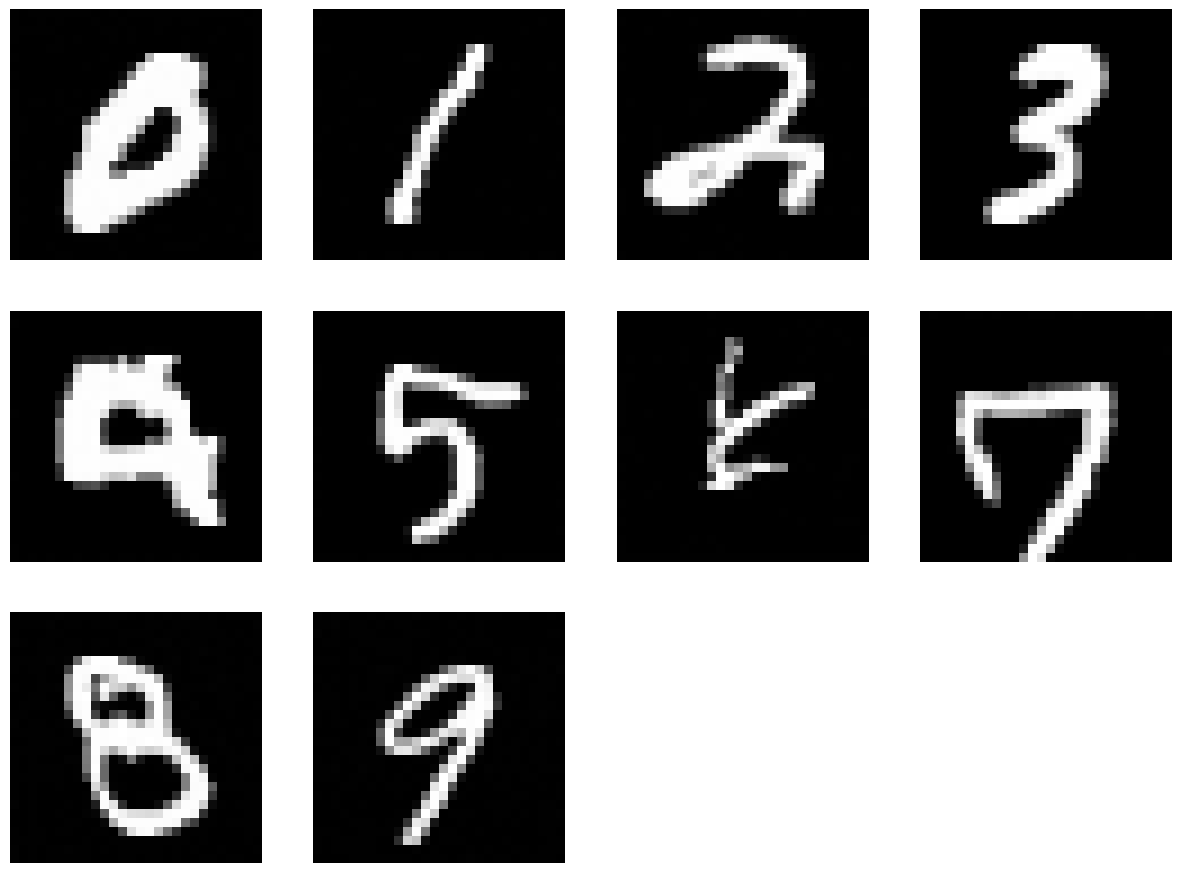

In [ ]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x0[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [27]:
labels_to_load = list(range(10))
images, labels = load_label_data(labels_to_load, "./mnist_split")
dataset3 = create_new_dataset(images, labels)
dataloader = DataLoader(dataset3, batch_size=300, shuffle=True)

In [28]:
data_9 = np.load('samples_0-9_xT-full.npz')
samples_9 = data_9['samples']
labels_9 = data_9['labels']
dataset_9 = create_new_dataset(torch.tensor(samples_9, dtype=torch.float32), torch.tensor(labels_9, dtype=torch.int64))
dataloader_9 = DataLoader(dataset_9, batch_size=200, shuffle=True)

In [29]:
samples_9 = torch.tensor(samples_9, dtype=torch.float32).to(device)
labels_9 = torch.tensor(labels_9, dtype=torch.long).to(device)

In [30]:
from torchcfm.conditional_flow_matching import *

In [31]:
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.1)

In [ ]:
def FlowMatching_loss(model, x, y,
                      device='cuda'):
    x = x.to(device)
    y = y.to(device)

    B = x.shape[0]

    z = torch.randn_like(x)
    z2 = torch.randn_like(x)
    a = 0.2*torch.rand(B, 1, 1, 1).to(device)
    x = (1 - a).sqrt() * x + a.sqrt() * z2
    t, x_t, u_t, _, y1 = FM.guided_sample_location_and_conditional_flow(z, x, y1=y) 


    pred_v = model(x_t, t.squeeze(-1), y1)
    return (u_t - pred_v).square().mean()

In [33]:
model_FM=UNetModelWrapper2(
    dim=(1, 28, 28),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=(1, 2, 2),
    num_heads=4,
    num_head_channels=32,
    attention_resolutions="16",
    dropout=0.1,
    class_cond=True,
    num_classes=10,
).to(device)
model_FM.train()

UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [ ]:
#from adopt import ADOPT
import os
def warmup_lr(step):
    return min(step, 5000) / 5000
def train_model_DDPM(model, dataloader, path,num_epoch=81,lr=1e-3, loss_fn = None,decay_steps = 20):
    if not os.path.exists(path):
        os.makedirs(path)
    seed = 1234
    print('Training model...')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lr)
    for epoch in range(num_epoch):
        model.train()
        epoch_losses = []

        for batch_x,labels_x in dataloader:
            batch_x = batch_x.to(device)
            #batch_x = batch_x*2-1
            y = labels_x.to(device)
            backup_state = {k: v.clone() for k, v in model.state_dict().items()}

            loss = loss_fn(model, batch_x, y)

            if torch.isnan(loss):
                model.load_state_dict(backup_state)
                for pg in optimizer.param_groups:
                    pg['lr'] *= 0.5
                    print(f"  → new lr: {pg['lr']:.2e}")
                continue

            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            sched.step()

            epoch_losses.append(loss.item())

        if epoch % decay_steps == 0 and len(epoch_losses) > 0:
            avg_loss = np.mean(epoch_losses)
            print(f"[Epoch {epoch}/{num_epoch}] loss: {avg_loss:.6f}")
            tmp_path = os.path.join(path, '.model.pth')
            torch.save(model.state_dict(), tmp_path)
            os.replace(tmp_path, os.path.join(path, 'model.pth'))
    final_path = os.path.join(path, 'model.pth')
    torch.save(model.state_dict(), final_path)
    print("Training Finished. Model saved to", final_path)

    return model

In [35]:
# 37min
path = 'FM3/mnist_3.2_noise_0.2'
#model_FM.load_state_dict(torch.load(f'{path}/model.pth', map_location=device))
model_FM = train_model_DDPM(model_FM, dataloader_9, path, num_epoch=50,lr=1e-4, loss_fn = FlowMatching_loss,decay_steps = EPOCH//50)
print('Training done!')
model_FM.eval()

Training model...
[Epoch 0/50] 平均 loss: 1.495191
[Epoch 10/50] 平均 loss: 0.934982
[Epoch 20/50] 平均 loss: 0.912340
[Epoch 30/50] 平均 loss: 0.902182
[Epoch 40/50] 平均 loss: 0.895116
Training Finished. Model saved to FM3/mnist_3.2_noise_0.2/model.pth
Training done!


UNetModelWrapper2(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (label_emb): Embedding(10, 256)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): 

In [36]:
for param in model_FM.parameters():
    param.requires_grad = False

In [37]:
class FMSampler:
    def __init__(self, model, device = 'cuda:0'):
        self.model = model
        self.device = device

    def score_function(self, x, y, t):
        '''
        Computes the score function for input data x at given time step t.

        The score function is a key concept in generative models, guiding the reverse process of data through a noise process.

        Parameters:
        - x (Tensor): The input data, typically noisy data at a certain time step t.
        - t (Tensor): A scalar or a tensor with the same batch size as x, representing the time step.

        Returns:
        - Tensor: The score function value for the input data x at time step t.
        '''
        # Expand the time step t to match the batch size of x and ensure it's on the correct device
        #print(t.shape,x.shape,y.shape)
        t_repeat = (t * torch.ones(x.shape[0])).to(self.device)
        pred_noise = self.model(x, t_repeat, y)
        # Calculate the value of the score function
        return pred_noise
    
    def score_function_rearange(self, t, x, y):
        return self.score_function(x, y, t)
    
    def score_function_1element(self, x, y, t):
        x = x.reshape(-1,x.shape[-1])
        score = self.score_function(x, y, t)
        return score.flatten()
    
    @torch.no_grad()
    def ode_step(self, x, y, t, t_next):
        function = lambda t, x: self.score_function_rearange(t, x, y)
        return odesolver(function, x, t, t_next)
    
    @torch.no_grad()
    def exact_dynamics(self, xT, y, timesteps, method = 'RK4'): 
        xt = xT
        function = lambda t, x: self.score_function_rearange(t, x, y)
        for i in range(len(timesteps)-1):
            t = timesteps[i]
            tnext = timesteps[i+1]
            xt = odesolver(function, xt, t, tnext, method)
            #xt=torch.clamp(xt, -2.0, 2.0).detach()
        return xt

In [38]:
num_steps = 1
Sampler_FM =FMSampler(model_FM,device)

exact_dynamics_FM = Sampler_FM.exact_dynamics
time_forward_FM = torch.flip(torch.linspace(0, 1, num_steps+1), dims=[0])
time_backward_FM = torch.flip(time_forward_FM, dims=[0])

In [39]:
batch_size = 10
xT=torch.randn(size=(batch_size,1,28,28)).to(device)  # (5,1,24,24)
yT=9*torch.ones(size=(batch_size,),dtype=torch.long).to(device)  # (5,)

In [40]:
x1 = exact_dynamics_FM(xT, yT, time_backward_FM)

In [41]:
x0 = exact_dynamics(x1, yT, time_backward)

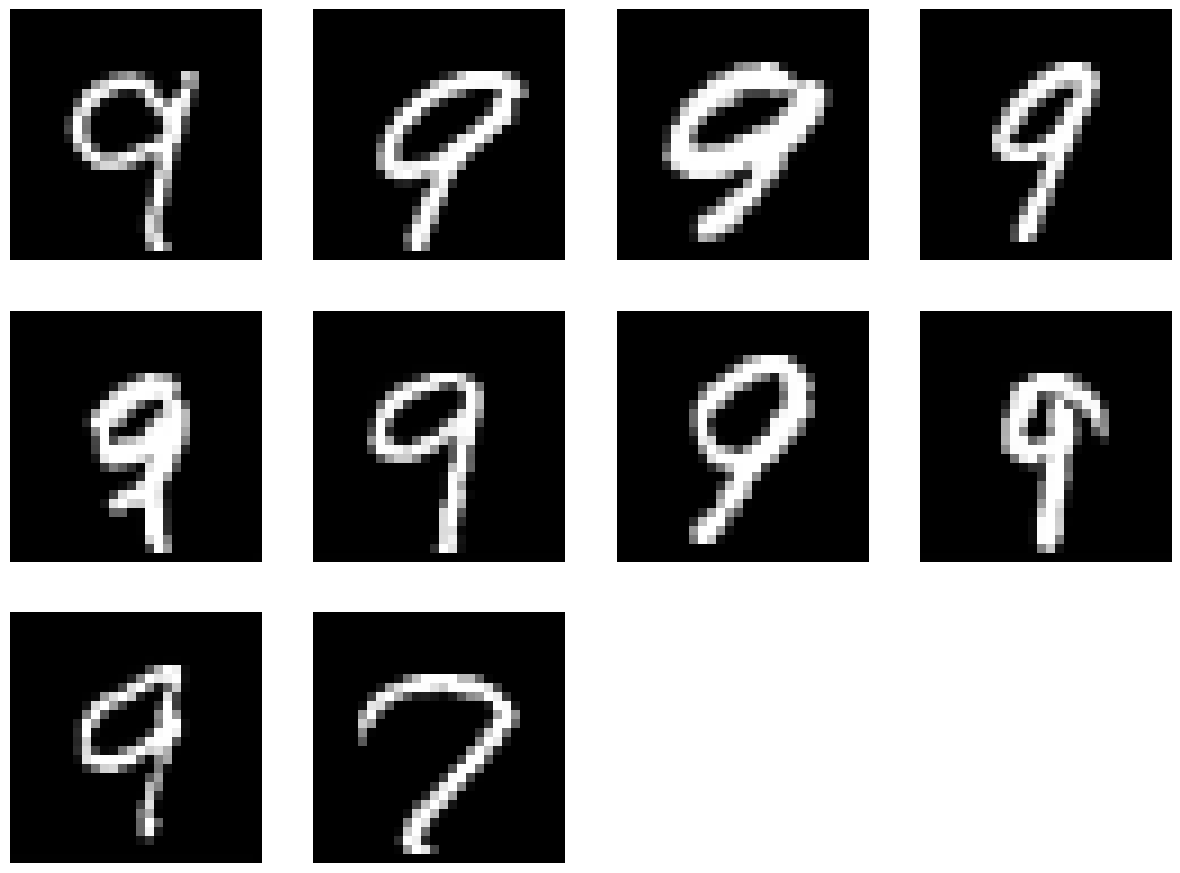

In [42]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x0[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [43]:
batch_size = 10
xT=torch.randn(size=(batch_size,1,28,28)).to(device)  # (5,1,24,24)
yT=torch.arange(start=0,end=10,dtype=torch.long).to(device)  # (5,)

In [44]:
x1 = exact_dynamics_FM(xT, yT, time_backward_FM)

In [45]:
x0 = exact_dynamics(x1, yT, time_backward)

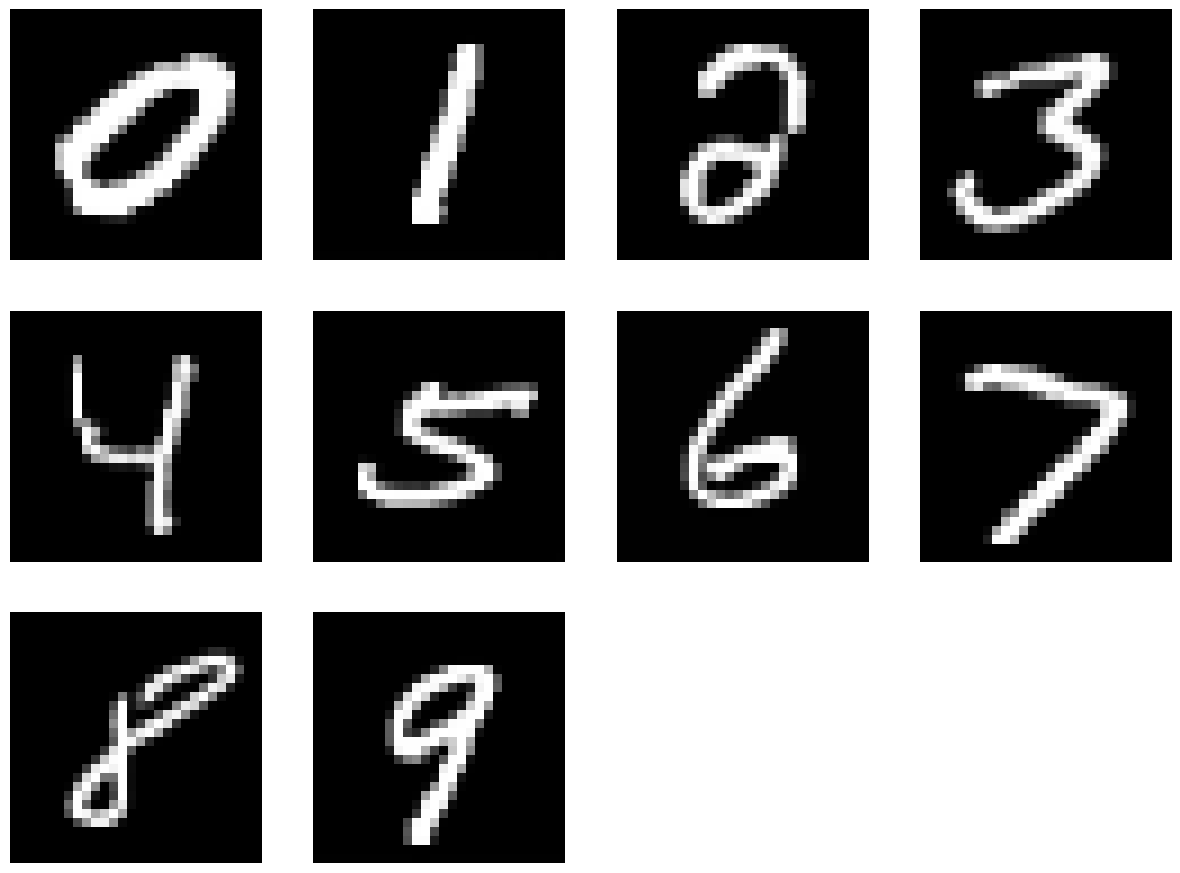

In [46]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x0[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [47]:
x3 = exact_dynamics(xT, yT, time_backward)

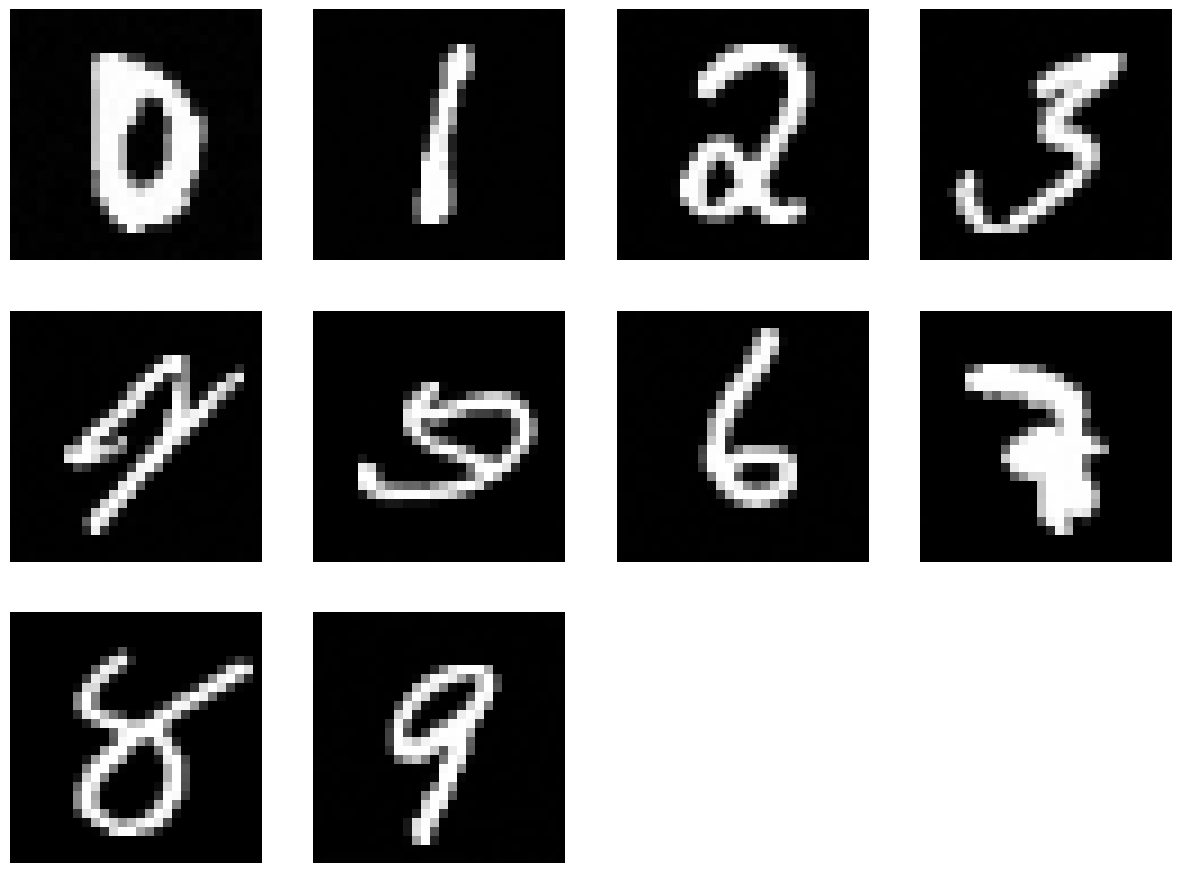

In [48]:
plt.figure(figsize=(15,15))
for b in range(batch_size):
    plt.subplot(4,4,b+1)
    plt.imshow(x3[b].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:

from tqdm import tqdm
batch_size = 500
num_samples = 50000
samples = []
labels = []
for i in tqdm(range(num_samples // batch_size)):
    xT = torch.randn(size=(batch_size, 1, 28, 28)).to(device)  # (10000,1,28,28)
    yT= torch.arange(start=0, end=10, dtype=torch.long).to(device)  # (10000,)
    yT = yT.repeat(batch_size // 10)  
    x1 = exact_dynamics_FM(xT, yT, time_backward_FM)
    x0 = exact_dynamics(x1, yT, time_backward)
    samples.append(x0.cpu().detach().numpy())
    labels.append(yT.cpu().detach().numpy())
samples = np.concatenate(samples, axis=0)
labels = np.concatenate(labels, axis=0)
np.savez('samples_LFR.npz', samples=samples, labels=labels)

100%|██████████| 100/100 [23:20<00:00, 14.00s/it]


In [51]:
immages_data = np.concatenate([images.numpy(), images.numpy(), images.numpy()], axis=1)

In [ ]:
samples_9 = (samples+1) / 2  
samples_9 = samples_9.clip(0, 1)  

In [53]:
samples_9 = np.concatenate([samples_9, samples_9, samples_9], axis=1)

In [54]:
immages_data = np.transpose(immages_data, (0, 2, 3, 1))
samples_9 = np.transpose(samples_9, (0, 2, 3, 1))
print(immages_data.min(), immages_data.max(), samples_9.min(), samples_9.max())

0.0 1.0 0.0 1.0


In [ ]:
import torch
from torch.utils.data import Dataset

class NumpyDatasetUInt8(Dataset):
    def __init__(self, data):

        if data.dtype != np.uint8:
            #data = (data+1)/2
            data = np.clip(data, 0, 1)  
            data = (data * 255).astype(np.uint8)

        self.data = torch.from_numpy(data)
        if self.data.ndim == 4 and self.data.shape[-1] in [1,3]:
            self.data = self.data.permute(0,3,1,2)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
real_ds = NumpyDatasetUInt8(immages_data)
fake_ds = NumpyDatasetUInt8(samples_9)

from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1=fake_ds,
    input2=real_ds,
    cuda=True,
    isc=True,
    fid=True,
    kid=True,  # sFID
    batch_size=100,
    verbose=True
)

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Processing samples                                                              
Extracting features from input2
Processing samples                                                              
Inception Score: 2.08542940529401525 ± 0.014900638619750722
Frechet Inception Distance: 1.4699708536693663
Kernel Inception Distance: 0.0008457534759760188 ± 0.000369704860005919         


In [116]:
print("FID  :", metrics['frechet_inception_distance'])
print("sFID :", metrics['kernel_inception_distance_mean'])
print("IS   :", metrics['inception_score_mean'])

FID  : 1.4699708536693663
sFID : 0.0008457534759760188
IS   : 2.08542940529401525
